<a href="https://www.kaggle.com/code/digvijaysingh25/rainfall-prediction-with-pytorch?scriptVersionId=227621323" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# 🌧️ **Binary Prediction with a Rainfall Dataset using PyTorch**  
🎯 *Kaggle Playground Series - Season 5, Episode 3*

---

### 📌 **Objective**
In this competition, we will build a **binary classification model** using **PyTorch** to predict the probability of rainfall for each day. The goal is to **maximize the ROC AUC score**, ensuring the model effectively differentiates between rainy (`1`) and non-rainy (`0`) days.

---

### 🔹 **Data Preprocessing & Feature Engineering**
- Extract and preprocess **weather-related features** from the dataset.
- Create **new engineered features** (e.g., `humidity-cloud interaction`, `relative dryness`).
- Apply **feature scaling** using `StandardScaler` to standardize inputs.

### 🔹 **Converting Data to PyTorch Tensors**
- Convert both **training and validation datasets** into **PyTorch tensors**.
- Split the data into **training and validation sets** with **stratified sampling**.
- Use **mini-batch processing** to efficiently train the model.

### 🔹 **Building a Neural Network in PyTorch**
- Define a **fully connected neural network (MLP)** using `torch.nn.Module`.
- Use **ReLU activation** for hidden layers and **Sigmoid activation** for binary classification.
- Implement **dropout layers** to reduce overfitting.

In [1]:
!pip install torchviz

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
import torch.optim as optim
from torchviz import make_dot
from torchsummary import summary
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# 🔍Data Loading and Initial Exploration

In [2]:
# Loading Data
train = pd.read_csv('/kaggle/input/playground-series-s5e3/train.csv')
test = pd.read_csv('/kaggle/input/playground-series-s5e3/test.csv')

In [3]:
# Display few rows of each dataset
print(f"Train Data Preview:")
display(train.head(), train.shape)

print("\nTest Data Preview:")
display(test.head(), test.shape)

Train Data Preview:


,id,day,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,sunshine,winddirection,windspeed,rainfall
0,0,1,1017.4,21.2,20.6,19.9,19.4,87.0,88.0,1.1,60.0,17.2,1
1,1,2,1019.5,16.2,16.9,15.8,15.4,95.0,91.0,0.0,50.0,21.9,1
2,2,3,1024.1,19.4,16.1,14.6,9.3,75.0,47.0,8.3,70.0,18.1,1
3,3,4,1013.4,18.1,17.8,16.9,16.8,95.0,95.0,0.0,60.0,35.6,1
4,4,5,1021.8,21.3,18.4,15.2,9.6,52.0,45.0,3.6,40.0,24.8,0


(2190, 13)


Test Data Preview:


,id,day,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,sunshine,winddirection,windspeed
0,2190,1,1019.5,17.5,15.8,12.7,14.9,96.0,99.0,0.0,50.0,24.3
1,2191,2,1016.5,17.5,16.5,15.8,15.1,97.0,99.0,0.0,50.0,35.3
2,2192,3,1023.9,11.2,10.4,9.4,8.9,86.0,96.0,0.0,40.0,16.9
3,2193,4,1022.9,20.6,17.3,15.2,9.5,75.0,45.0,7.1,20.0,50.6
4,2194,5,1022.2,16.1,13.8,6.4,4.3,68.0,49.0,9.2,20.0,19.4


(730, 12)

In [4]:
# Total missing values in train and test
missing_values = pd.DataFrame({
    'train': train.isnull().sum(),
    'test': test.isnull().sum(), 
    'data_types': train.dtypes
})
print(missing_values)

               train  test data_types
cloud              0   0.0    float64
day                0   0.0      int64
dewpoint           0   0.0    float64
humidity           0   0.0    float64
id                 0   0.0      int64
maxtemp            0   0.0    float64
mintemp            0   0.0    float64
pressure           0   0.0    float64
rainfall           0   NaN      int64
sunshine           0   0.0    float64
temparature        0   0.0    float64
winddirection      0   1.0    float64
windspeed          0   0.0    float64


### Features
- `day`
- `pressure`
- `maxtemp`
- `temparature` 
- `mintemp`
- `dewpoint`
- `humidity`
- `cloud`
- `sunshine`
- `winddirection`
- `windspeed`

### Target Variable (`rainfall`)
- Present in the **train** dataset.
- Binary representation:
  - `0` = No rain
  - `1` = Rain

### Missing Values
| Dataset       | Feature         | Missing Values |
|---------------|-----------------|----------------|
| Test Data     | `winddirection` | 1              |
| Train Data    | -               | 0              

### Duplicate Rows
- **Train Data**: 0 duplicated rows.
- **Test Data**: 0 duplicated rows.

### Data Shape
- **Train Data**: 2190 rows x 13 columns
- **Test Data**: 730 rows x 12 columns

In [5]:
# Replace missing values in the 'winddirection' column of the test dataset with its mean
test.winddirection = test.winddirection.fillna(test.winddirection.mean())

# ⚙️ **Feature Engineering**  

In [6]:
# some new features
train['humidity_cloud_interaction'] = train['humidity'] * train['cloud']
train['humidity_sunshine_interaction'] = train['humidity'] * train['sunshine']
train['cloud_sunshine_ratio'] = train['cloud'] / (train['sunshine'] + 1e-5)
train['relative_dryness'] = 100 - train['humidity']
train['sunshine_percentage'] = train['sunshine'] / (train['sunshine'] + train['cloud'] + 1e-5)
train['weather_index'] = (0.4 * train['humidity']) + (0.3 * train['cloud']) - (0.3 * train['sunshine'])

test['humidity_cloud_interaction'] = test['humidity'] * test['cloud']
test['humidity_sunshine_interaction'] = test['humidity'] * test['sunshine']
test['cloud_sunshine_ratio'] = test['cloud'] / (test['sunshine'] + 1e-5)
test['relative_dryness'] = 100 - test['humidity']
test['sunshine_percentage'] = test['sunshine'] / (test['sunshine'] + test['cloud'] + 1e-5)
test['weather_index'] = (0.4 * test['humidity']) + (0.3 * test['cloud']) - (0.3 * test['sunshine'])

### 🛠️ Generated Features & Their Descriptions
The following features have been engineered to enhance weather-related predictions:

#### 1️⃣ **Humidity-Cloud Interaction (`humidity_cloud_interaction`)**
   - Computed as:  
     $$
     \text{humidity_cloud_interaction} = \text{humidity} \times \text{cloud}
     $$
   - Measures the combined effect of **humidity** and **cloud cover**, providing insight into how moisture and cloud density correlate.

#### 2️⃣ **Humidity-Sunshine Interaction (`humidity_sunshine_interaction`)**
   - Computed as:  
     $$
     \text{humidity_sunshine_interaction} = \text{humidity} \times \text{sunshine}
     $$
   - Captures the **relationship between humidity and sunshine**, which might impact heat index or evaporative cooling.

#### 3️⃣ **Cloud-Sunshine Ratio (`cloud_sunshine_ratio`)**
   - Computed as:  
     $$
     \text{cloud_sunshine_ratio} = \frac{\text{cloud}}{\text{sunshine} + 1e-5}
     $$
   - Represents the **proportion of cloud cover relative to sunshine**.
   - The small value `1e-5` prevents division errors when sunshine is **zero**.

#### 4️⃣ **Relative Dryness (`relative_dryness`)**
   - Computed as:  
     $$
     \text{relative_dryness} = 100 - \text{humidity}
     $$
   - Indicates **how dry the atmosphere is**, which may be useful in predicting clear skies and dry conditions.

#### 5️⃣ **Sunshine Percentage (`sunshine_percentage`)**
   - Computed as:  
     $$
     \text{sunshine_percentage} = \frac{\text{sunshine}}{\text{sunshine} + \text{cloud} + 1e-5}
     $$
   - Expresses the **proportion of sunshine relative to total sky coverage** (cloud + sunshine).
   - Helps in identifying **sunny vs. overcast days**.

#### 6️⃣ **Weather Index (`weather_index`)**
   - Computed as:  
     $$
     \text{weather_index} = (0.4 \times \text{humidity}) + (0.3 \times \text{cloud}) - (0.3 \times \text{sunshine})
     $$
   - A weighted formula to create a **custom weather score**:
     - **Higher values** → Cloudy, humid conditions.
     - **Lower values** → Sunnier, drier conditions.
   - Could be useful as a **simplified indicator of weather severity**.

---

### 🔍 **Potential Benefits of These Features**
✅ **Improved Weather Predictions**:  
   - These features introduce **non-linear relationships** between key variables.  
✅ **More Interpretability**:  
   - Metrics like **Relative Dryness** and **Weather Index** provide a direct **understanding of atmospheric conditions**.  
✅ **Avoiding Data Issues**:  
   - Small adjustments (`+1e-5`) prevent **division errors** in cases of zero sunshine.  

---

# 🔄 Data Preprocessing for Rainfall Prediction
## 🔹 1. Separating Features and Target

In [7]:
train.columns

Index(['id', 'day', 'pressure', 'maxtemp', 'temparature', 'mintemp',
       'dewpoint', 'humidity', 'cloud', 'sunshine', 'winddirection',
       'windspeed', 'rainfall', 'humidity_cloud_interaction',
       'humidity_sunshine_interaction', 'cloud_sunshine_ratio',
       'relative_dryness', 'sunshine_percentage', 'weather_index'],
      dtype='object')

In [8]:
# Separate features and target
feature_cols = ['pressure', 'maxtemp', 'temparature', 'mintemp',
       'dewpoint', 'humidity', 'cloud', 'sunshine', 'winddirection',
       'windspeed', 'humidity_cloud_interaction',
       'humidity_sunshine_interaction', 'cloud_sunshine_ratio',
       'relative_dryness', 'sunshine_percentage', 'weather_index']

X = train[feature_cols].values
y = train['rainfall'].values

We extract the **independent variables** (features) and the **dependent variable** (target: `rainfall`).

#### ✅ Features (`X`)
The selected features include **weather-related attributes** along with engineered features:
- `pressure`, `maxtemp`, `temparature` (⚠️ Possible typo: should be `temperature`), `mintemp`, `dewpoint`, `humidity`, `cloud`, `sunshine`, `winddirection`, `windspeed`
  
- **Engineered Features**:
  - `humidity_cloud_interaction`
  - `humidity_sunshine_interaction`
  - `cloud_sunshine_ratio`
  - `relative_dryness`
  - `sunshine_percentage`
  - `weather_index`

#### 🎯 Target (`y`)
- The binary target variable **`rainfall`** (`0` = No Rain, `1` = Rain).

## 🔹 2. Splitting Data into Training & Validation Sets

In [9]:
# Split into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=0.2,   # 20% data for validation
    random_state=42, # Ensures reproducibility
    stratify=y       # Maintains class balance
)

* To ensure a balanced distribution of classes, we use **stratified sampling** (`stratify=y`), preserving the proportion of rainfall occurrence.

## 🔹 3. Feature Scaling

In [10]:
# Scale features (helps neural networks converge faster)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val   = scaler.transform(X_val)

**Why Scale Features?**
- Neural networks converge **faster** when inputs have **zero mean** and **unit variance**.
- Standardization ensures features with different magnitudes (e.g., wind speed vs. pressure) do not dominate training.

## 🔹 4. Converting Data to PyTorch Tensors

In [11]:
# Convert to PyTorch tensors
X_train_t = torch.tensor(X_train, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)  # shape (batch_size, 1)
X_val_t   = torch.tensor(X_val, dtype=torch.float32)
y_val_t   = torch.tensor(y_val, dtype=torch.float32).view(-1, 1)

- **PyTorch requires tensors** for training deep learning models.
- The `view(-1, 1)` ensures `y` is reshaped to **(batch_size, 1)** format for compatibility with neural networks.

# ⚡ Simple Neural Network for Rainfall Prediction

### 📌 Overview
This is a simple **feedforward neural network** built using **PyTorch** to predict whether it will rain (`rainfall` = `0` or `1`). The model consists of:
- **An input layer** with features representing weather conditions.
- **A hidden layer** with ReLU activation.
- **An output layer** without activation function because we're using **BCEWithLogitsLoss** which internally applies a sigmoid function.

In [12]:
class SimpleRainfallNet(nn.Module):
    def __init__(self, input_dim, hidden_dim=16, dropout=0.5):
        super(SimpleRainfallNet, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.bn1 = nn.BatchNorm1d(hidden_dim)  # Added Batch Normalization layer
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=dropout)
        self.fc2 = nn.Linear(hidden_dim, 1) # No sigmoid here; handled by BCEWithLogitsLoss

    def forward(self, x):
        x = self.fc1(x)
        x = self.bn1(x)  # Normalize the output of fc1
        x = self.relu(x)
        x = self.dropout(x)  
        x = self.fc2(x)
        return x

# Example initialization:
input_dim = len(feature_cols)
hidden_dim = 16
dropout = 0.3
model = SimpleRainfallNet(input_dim, hidden_dim, dropout=dropout)

# Summary
summary(model, (input_dim,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 16]             272
       BatchNorm1d-2                   [-1, 16]              32
              ReLU-3                   [-1, 16]               0
           Dropout-4                   [-1, 16]               0
            Linear-5                    [-1, 1]              17
Total params: 321
Trainable params: 321
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------


### 🏗️ Model Architecture

#### 1️⃣ **Input Layer**
- The number of input neurons equals the number of selected **weather-related features** (`input_dim`).

#### 2️⃣ **Hidden Layer**
- A fully connected (`Linear`) layer with **16 neurons** (`hidden_dim=16`).
- **ReLU Activation (`ReLU()`)** is applied to introduce non-linearity.
- **Dropout layer** for regularization

#### 3️⃣ **Output Layer**
- Single neuron with **no explicit activation**.
- Raw logits output (sigmoid is applied internally by **BCEWithLogitsLoss** during training)

| Layer  | Type       | Details |
|--------|-----------|---------|
| Input  | `nn.Linear`  | **`input_dim` neurons** (one per feature) |
| Hidden | `nn.Linear`  | **16 neurons** with `ReLU` activation |
| Output | `nn.Linear`  | **1 neuron** (raw logits for classification)|


This model serves as a **lightweight baseline** for rainfall prediction! 🌧️💡

### 🧠🔍 Visualizing Neural Network Architecture with `torchviz`
To **better understand** the structure of the neural network, we can use **`torchviz`** to generate a computational graph.

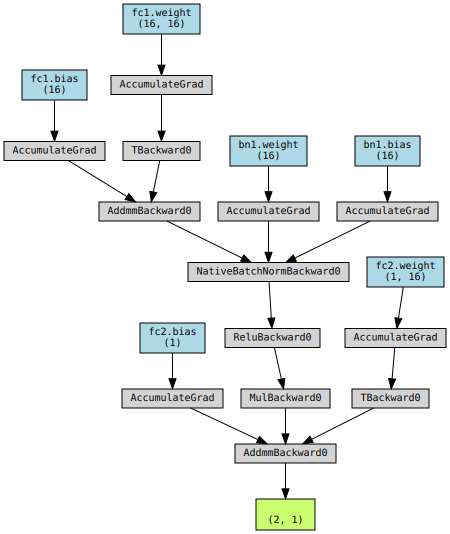

In [13]:
# Create a dummy input tensor with the right dimensions (batch_size, input_dim)
dummy_input = torch.randn(2, input_dim)

# Perform a forward pass
output = model(dummy_input)

# Generate the architecture diagram
dot = make_dot(output, params=dict(model.named_parameters()))
dot

#### **Class Distribution**
Before training, we check the distribution of the `rainfall` labels in the dataset:

In [14]:
train.rainfall.value_counts()

rainfall
1    1650
0     540
Name: count, dtype: int64

This helps us identify if the dataset is **imbalanced** (i.e., more instances of `1` than `0`), which can affect model performance.

### ⚖️ **Addressing Class Imbalance with Weighted Loss**
Since the dataset is imbalanced (more `rainfall=1` samples), we use `pos_weight` to adjust for the **minority class (`rainfall=0`)**.

In [15]:
pos_weight_value = (len(train)-sum(train['rainfall'])) / sum(train['rainfall'])

### **1️⃣ Compute Class Weight**
- The weight is computed as **(number of negative samples / number of positive samples)**.
- This ensures that the model **does not favor the majority class**.

In [16]:
criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([pos_weight_value]))

### **2️⃣ Define Weighted Loss Function**
- **`BCEWithLogitsLoss`** is preferred over `BCELoss` because it combines **Sigmoid activation + Binary Cross-Entropy Loss**, improving numerical stability.
- **`pos_weight`** adjusts the loss function to **penalize misclassifications** in the minority class.

In [17]:
# weight_decay applies L2 regularization to reduce overfitting
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-2)











### **3️⃣ Define Optimizer with L2 Regularization**

- **`Adam` Optimizer**: Adaptive learning rate adjustment for better convergence.
- **Learning Rate (`lr=0.001`)**: Controls how much the weights update per step.
- **L2 Regularization (`weight_decay=1e-2`)**: Prevents overfitting by adding a penalty for large weights.


By using **pos_weight**, we ensure that the model gives **equal importance** to predicting rainy and non-rainy days, improving classification performance. 🌦️🚀

# 🏋️‍♂️ Training a Neural Network for Rainfall Prediction

### 📌 Overview
This script trains a **binary classification model** using **mini-batches** and implements **early stopping** to prevent overfitting.

## 🔹 **1. Define Training Parameters**

In [18]:
num_epochs = 200
batch_size = 32



- **`num_epochs = 200`**: Maximum training iterations.
- **`batch_size = 32`**: Processes **32 samples per step**, improving stability.

---

## 🔹 **2. Mini-Batch Function**
We define a helper function to yield mini-batches:

In [19]:
def get_batches(X, y, batch_size):
    for i in range(0, len(X), batch_size):
        yield X[i:i+batch_size], y[i:i+batch_size]



- This **splits training data into smaller chunks**, reducing memory usage.
- The `yield` statement allows **efficient batch processing**.

---

## 🔹 **3. Initialize Early Stopping**

In [20]:
best_val_loss = float('inf')  # Best validation loss starts at infinity
patience = 50  # Stop training if no improvement for 10 epochs
no_improve_count = 0  # Tracks epochs without improvement

- **Best validation loss (`best_val_loss`)** keeps track of the best-performing model.
- **`patience = 50`** means if validation loss doesn't improve for 50 consecutive epochs, training stops.

---

## 🔹 **4. Training Loop**

In [21]:
for epoch in range(num_epochs):
    # Enable training mode (activates dropout layers)
    model.train()
    epoch_loss = 0.0
    
    # Shuffle data each epoch
    perm = torch.randperm(X_train_t.size(0))
    X_train_t = X_train_t[perm]
    y_train_t = y_train_t[perm]
    
    for X_batch, y_batch in get_batches(X_train_t, y_train_t, batch_size):
        optimizer.zero_grad()  # Reset gradients
        outputs = model(X_batch)  # Forward pass
        loss = criterion(outputs, y_batch)  # Compute loss
        
        loss.backward()  # Backpropagation
        optimizer.step()  # Update weights
        
        epoch_loss += loss.item() * X_batch.size(0)
    
    epoch_loss /= len(X_train_t)  # Normalize loss

    # VALIDATION
    model.eval()  # disables dropout
    with torch.no_grad():
        val_outputs = model(X_val_t)
        val_loss = criterion(val_outputs, y_val_t).item()
        
        # Convert outputs and true labels to numpy arrays for roc_auc_score
        val_outputs_np = val_outputs.detach().cpu().numpy().flatten()
        y_val_np = y_val_t.detach().cpu().numpy().flatten()
        roc_auc = roc_auc_score(y_val_np, val_outputs_np)
    
    # Print progress every 10 epochs
    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}] | "
              f"Train Loss: {epoch_loss:.4f} | "
              f"Val Loss: {val_loss:.4f} | "
              f"ROC AUC: {roc_auc:.4f}")
    
    # EARLY STOPPING CHECK
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        no_improve_count = 0
    else:
        no_improve_count += 1
        if no_improve_count >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break


Epoch [10/200] | Train Loss: 0.2752 | Val Loss: 0.2682 | ROC AUC: 0.8693
Epoch [20/200] | Train Loss: 0.2417 | Val Loss: 0.2411 | ROC AUC: 0.8789
Epoch [30/200] | Train Loss: 0.2277 | Val Loss: 0.2272 | ROC AUC: 0.8823
Epoch [40/200] | Train Loss: 0.2196 | Val Loss: 0.2191 | ROC AUC: 0.8847
Epoch [50/200] | Train Loss: 0.2110 | Val Loss: 0.2165 | ROC AUC: 0.8848
Epoch [60/200] | Train Loss: 0.2109 | Val Loss: 0.2139 | ROC AUC: 0.8840
Epoch [70/200] | Train Loss: 0.2097 | Val Loss: 0.2144 | ROC AUC: 0.8834
Epoch [80/200] | Train Loss: 0.2102 | Val Loss: 0.2144 | ROC AUC: 0.8826
Epoch [90/200] | Train Loss: 0.2085 | Val Loss: 0.2132 | ROC AUC: 0.8822
Epoch [100/200] | Train Loss: 0.2083 | Val Loss: 0.2133 | ROC AUC: 0.8820
Epoch [110/200] | Train Loss: 0.2086 | Val Loss: 0.2135 | ROC AUC: 0.8818
Epoch [120/200] | Train Loss: 0.2098 | Val Loss: 0.2146 | ROC AUC: 0.8808
Epoch [130/200] | Train Loss: 0.2078 | Val Loss: 0.2145 | ROC AUC: 0.8804
Epoch [140/200] | Train Loss: 0.2070 | Val Loss

- **`model.train()`**: Enables dropout & batch normalization (if used).
- **Data shuffling (`perm = torch.randperm`)** ensures different mini-batches each epoch.
- **`optimizer.zero_grad()`**: Clears previous gradients.
- **`loss.backward()`**: Computes gradients via backpropagation.
- **`optimizer.step()`**: Updates model weights.

---

## 🔹 **5. Validation Step**


- **`model.eval()`**: Turns off dropout layers for stable predictions.
- **`torch.no_grad()`**: Disables gradient tracking, reducing memory usage.

---

## 🔹 **6. Progress Display**



- Outputs loss **every 10 epochs** for tracking progress.

---

## 🔹 **7. Early Stopping Implementation**


- **Stops training if no improvement for 50 epochs**.
- **Helps prevent overfitting** by stopping before performance degrades.

---

This approach ensures an **efficient, stable, and generalizable** model for rainfall prediction! 🌧️🚀

---

# 📈 Evaluating Model Performance with ROC AUC Score

### 📌 Overview
To measure the effectiveness of our **binary classification model**, we compute the **ROC AUC (Receiver Operating Characteristic - Area Under Curve) score**.  
- **ROC AUC** evaluates the model’s ability to **distinguish between classes** (`rainfall = 0` vs. `rainfall = 1`).
- A score of **0.5** indicates a random classifier, while **1.0** represents a perfect classifier.

---

## 🔹 **1. Perform Model Evaluation**
We disable gradient calculations (`torch.no_grad()`) and set the model to **evaluation mode (`model.eval()`)** before making predictions.


In [22]:
model.eval()
with torch.no_grad():
    val_preds_np = torch.sigmoid(model(X_val_t)).cpu().numpy().ravel()
    y_val_np = y_val_t.cpu().numpy().ravel()

- **`model.eval()`** → Disables dropout & batch normalization layers (if used).
- **`torch.no_grad()`** → Prevents gradient calculations, reducing memory usage.
- **`val_preds.cpu().numpy().ravel()`** → Converts **PyTorch tensor** to a **NumPy array** and flattens it to **1D**.
- **`y_val_t.cpu().numpy().ravel()`** → Converts true labels to **NumPy format**.

---

## 🔹 **2. Compute ROC AUC Score**

In [23]:
roc_auc = roc_auc_score(y_val_np, val_preds_np)
print(f"Validation ROC AUC: {roc_auc:.4f}")

Validation ROC AUC: 0.8810


- **`roc_auc_score(y_true, y_scores)`** computes the area under the ROC curve.
- **Higher values (`0.9+`) indicate strong model performance**.

---

## 🔹 3. Plot ROC Curve

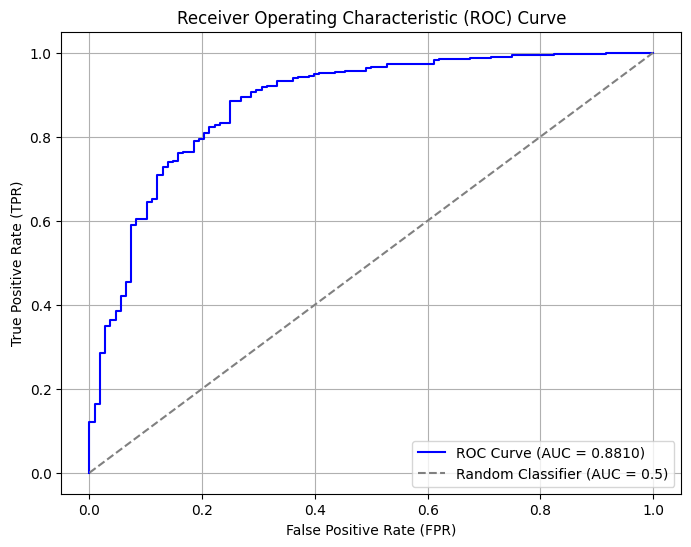

In [24]:
# Compute False Positive Rate (FPR), True Positive Rate (TPR), and Thresholds
fpr, tpr, thresholds = roc_curve(y_val_np, val_preds_np)

# Plot ROC Curve
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='grey', label='Random Classifier (AUC = 0.5)')

# Labels and Titles
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.grid()
plt.show()

# 📤 Generating Predictions & Creating Submission File

### 📌 Overview
This script:
1. **Preprocesses the test dataset** (using the same feature transformations as training).
2. **Performs inference using the trained PyTorch model**.
3. **Saves predictions to a CSV file** for submission.

---

## 🔹 **1. Load Test Data & Extract Features**
We extract the **test sample IDs** and ensure we use the **same feature set as training**.

In [25]:
# Suppose 'test' is your test DataFrame
test_ids = test["id"]  # or the appropriate ID column

# The same feature columns used in training
feature_cols = ['pressure', 'maxtemp', 'temparature', 'mintemp',
       'dewpoint', 'humidity', 'cloud', 'sunshine', 'winddirection',
       'windspeed', 'humidity_cloud_interaction',
       'humidity_sunshine_interaction', 'cloud_sunshine_ratio',
       'relative_dryness', 'sunshine_percentage', 'weather_index']

- **`test["id"]`** → Keeps track of which sample each prediction belongs to.
- **Ensures feature consistency** → Uses the exact same feature set as training.

---

## 🔹 **2. Preprocess Test Data**
- **Apply the same scaling transformation** (`StandardScaler`) used in training.

In [26]:
# Preprocess the test data (apply same scaling)
X_test = test[feature_cols].values
X_test = scaler.transform(X_test)  # Use the same scaler from training


- **`scaler.transform(X_test)`** → Ensures test features match the model’s training scale.

---

## 🔹 **3. Convert to PyTorch Tensor & Run Inference**
- **Set model to evaluation mode (`model.eval()`)**.
- **Disable gradients (`torch.no_grad()`)** to speed up inference.
- **Perform a forward pass** to obtain probability scores.

In [27]:
# Convert to torch tensor
X_test_t = torch.tensor(X_test, dtype=torch.float32)

# Set model to evaluation mode
model.eval()

# Disable gradient computation during inference
with torch.no_grad():
    # Forward pass: get probabilities
    y_pred_proba = model(X_test_t).cpu().numpy().ravel() # Apply sigmoid to convert logits to probabilities [0,1]


- **`model.eval()`** → Ensures dropout & batch normalization (if used) behave correctly.
- **`torch.no_grad()`** → Prevents unnecessary gradient calculations.
- **`cpu().numpy().ravel()`** → Converts PyTorch tensor to a **NumPy 1D array**.

---

## 🔹 **4. Create Submission File**

In [28]:
# Create a submission DataFrame
submission = pd.DataFrame({
    'id': test_ids,
    'rainfall': y_pred_proba
})

# Save to CSV
submission.to_csv("submission.csv", index=False)
print("PyTorch submission file created!")

PyTorch submission file created!



- **Creates a DataFrame with `id` and `rainfall` predictions**.
- **Saves it as `submission.csv`** (ready for submission).

---

# 🤝 **Connect with me**  
If you liked this notebook, feel free to connect with me on [LinkedIn](https://www.linkedin.com/in/digvijaysh) 😊